In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

housing_df_full = pd.read_csv('data/train.csv', index_col='Id')
housing_test_full = pd.read_csv('data/test.csv', index_col='Id')
housing_df_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
housing_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

### Things to improve: 
- Better Model (XGBoost)
- Make sure categorical features are treated as such (like `MSSubClass` is now being treated as a numerical column)
- Apply log to skewed distributions
- Create even more new features (feature engineering)
- Drop redundant features like `Neighborhood` after target encoding
- Remove outliers
- Better imputation (KNN imputer)

In [3]:
X = housing_df_full.copy()
housing_test = housing_test_full.copy()

### Outlier Removal

#### GrLivArea

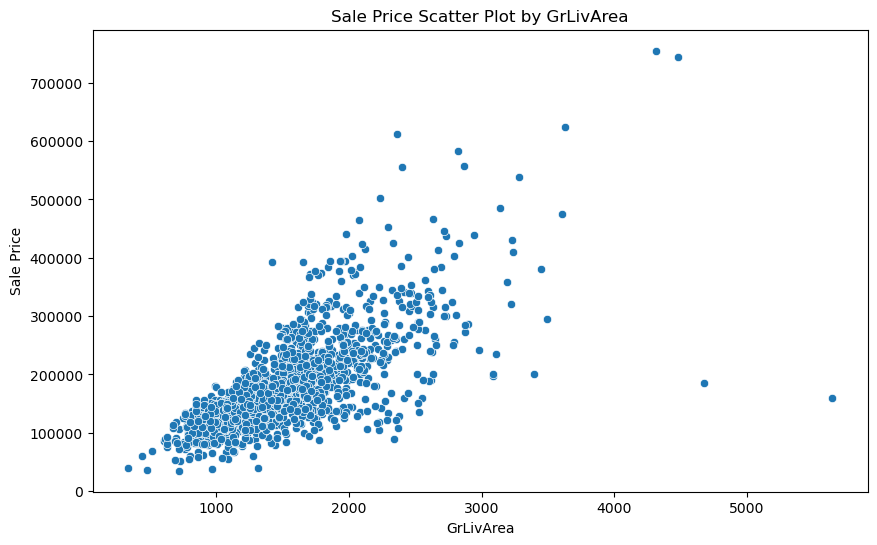

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['GrLivArea'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')
plt.show()

In [5]:
# Remove the extreme outliers recommended by the dataset author
X = X[X['GrLivArea'] < 4000]

#### IQR Method

##### LotArea

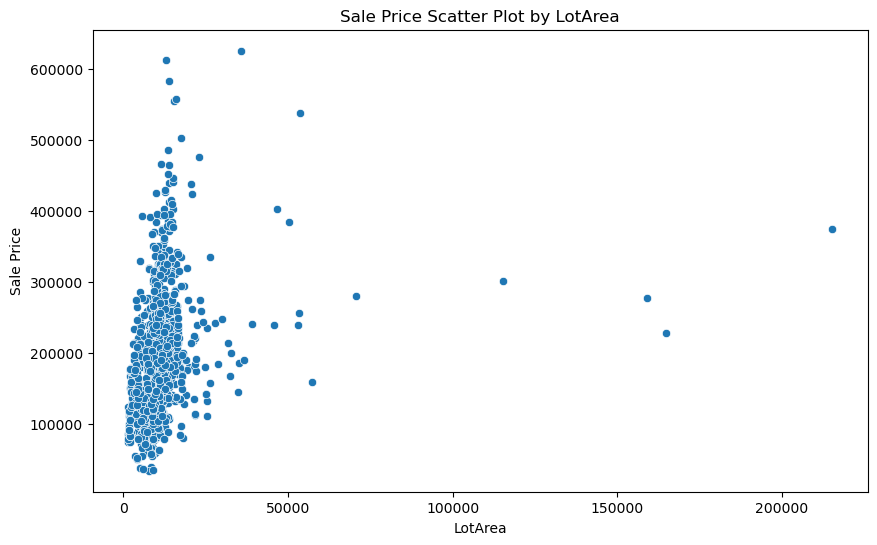

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['LotArea'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by LotArea')
plt.xlabel('LotArea')
plt.ylabel('Sale Price')
plt.show()

In [7]:
# A common rule of thumb: 1.5 * IQR
Q1 = X['LotArea'].quantile(0.25)
Q3 = X['LotArea'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Careful: Only remove extreme outliers so you don't lose too much data
outliers = X[(X['LotArea'] < lower_bound) | (X['LotArea'] > upper_bound)]

X = X.drop(outliers.index)

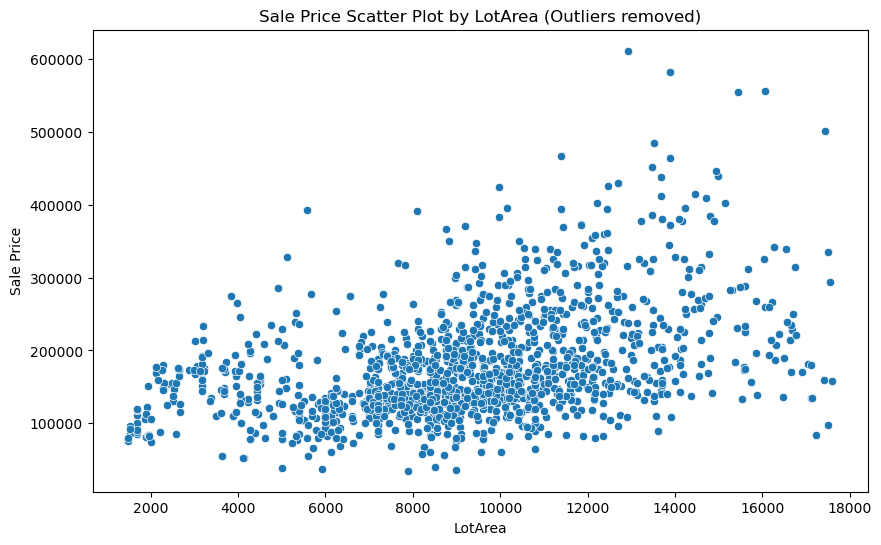

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['LotArea'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by LotArea (Outliers removed)')
plt.xlabel('LotArea')
plt.ylabel('Sale Price')
plt.show()

##### MasVnrArea

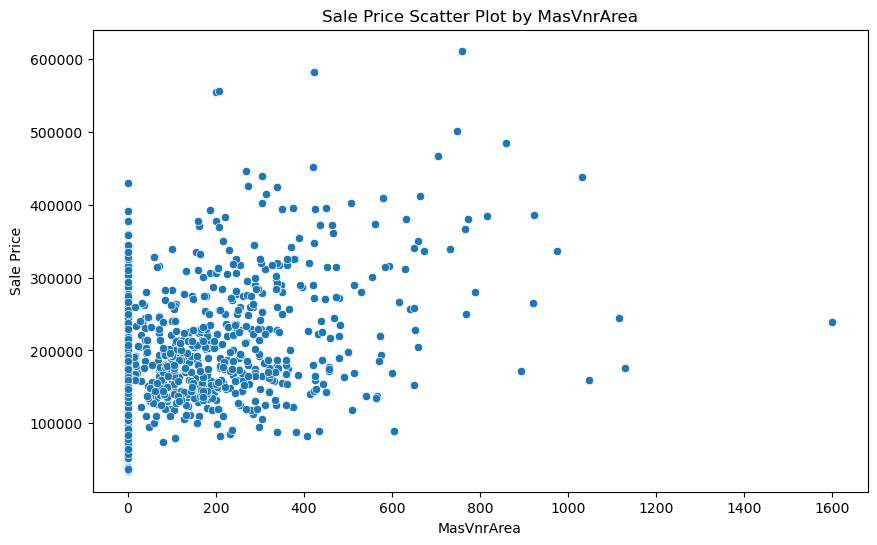

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['MasVnrArea'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by MasVnrArea')
plt.xlabel('MasVnrArea')
plt.ylabel('Sale Price')
plt.show()

In [10]:
# A common rule of thumb: 1.5 * IQR
Q1 = X['MasVnrArea'].quantile(0.25)
Q3 = X['MasVnrArea'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Careful: Only remove extreme outliers so you don't lose too much data
outliers = X[(X['MasVnrArea'] < lower_bound) | (X['MasVnrArea'] > upper_bound)]
# X = X.drop(outliers.index)

Nearly ~100 entries removed!

In [11]:
housing_df_full.shape,X.shape

((1460, 80), (1390, 80))

### Handling features with frequent missing values

Features with 40% or more missing values

In [12]:
missing_value_features = X.columns[((X.isna()).sum() >= X.shape[0] * 0.4)]
missing_value_features

Index(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

Features' missing values with percentage

In [13]:
missing_values = X.isna().sum()
missing_values_pct = (X.isna().sum() / X.shape[0]) * 100

missing_values_df = pd.DataFrame({'Missing Values': missing_values,'Missing Values %': missing_values_pct})
missing_values_df = missing_values_df.round(2)
missing_values_df.sort_values(by='Missing Values', ascending=False, inplace=True)
missing_values_df.head(10)

,Missing Values,Missing Values %
PoolQC,1387,99.78
MiscFeature,1340,96.40
Alley,1300,93.53
Fence,1119,80.50
MasVnrType,828,59.57
FireplaceQu,680,48.92
LotFrontage,233,16.76
GarageQual,80,5.76
GarageType,80,5.76
GarageFinish,80,5.76


#### Alley

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access


In [14]:
X.Alley.value_counts(dropna=False)

Alley
NaN     1300
Grvl      49
Pave      41
Name: count, dtype: int64

In [15]:
X.fillna({'Alley': 'None'}).groupby('Alley')['SalePrice'].agg(['mean'])

,mean
Alley,
Grvl,121284.775510
None,180095.080769
Pave,168000.585366


Instead of dropping the Alley variable or keeping it as is, we will encode it into HasAlley

In [16]:
X.fillna({'Alley': 'None'}, inplace=True)

X['HasAlley'] = X['Alley'].apply(lambda x: 0 if x == 'None' else 1)
housing_test['HasAlley'] = housing_test['Alley'].apply(lambda x: 0 if x == 'None' else 1)

X.drop('Alley', axis=1, inplace=True)
housing_test.drop('Alley', axis=1, inplace=True)

X['HasAlley'].value_counts()

HasAlley
0    1300
1      90
Name: count, dtype: int64

In [17]:
X.groupby('HasAlley')['SalePrice'].agg(['mean'])

,mean
HasAlley,
0,180095.080769
1,142566.422222


#### MsnVnrType

NaN values for `MasVnrType` signify non-existent mason veneer when `MasVnrArea` is also 0.0

In [18]:
X['MasVnrType'].value_counts(dropna=False)

MasVnrType
NaN        828
BrkFace    427
Stone      123
BrkCmn      12
Name: count, dtype: int64

5 Houses have MasVnrArea but no Type.

In [19]:
# Check if MasVnrArea is 0 when Type is NaN
print(X[X['MasVnrType'].isnull()]['MasVnrArea'].value_counts())

MasVnrArea
0.0      817
288.0      1
1.0        1
344.0      1
312.0      1
Name: count, dtype: int64


We can impute them with the global mode or by figuring out their neighborhood average

In [20]:
# Helper function to return the first mode, or 'None' if the group is empty
def get_mode(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else "None"

# Group by Neighborhood and Quality to find the most common type for that 'peer group'
peer_group_modes = X.groupby(['Neighborhood', 'OverallQual'])['MasVnrType'].apply(get_mode)

In [21]:
peer_group_modes

Neighborhood  OverallQual
Blmngtn       7              BrkFace
              8              BrkFace
Blueste       6                 None
BrDale        5              BrkFace
              6              BrkFace
                              ...   
Timber        9              BrkFace
Veenker       5                 None
              6              BrkFace
              7                 None
              8                 None
Name: MasVnrType, Length: 111, dtype: object

In [22]:
# Reset index to make it easy to join
peer_modes_df = peer_group_modes.reset_index(name='PeerMode')
peer_modes_df

,Neighborhood,OverallQual,PeerMode
0,Blmngtn,7,BrkFace
1,Blmngtn,8,BrkFace
2,Blueste,6,None
3,BrDale,5,BrkFace
4,BrDale,6,BrkFace
...,...,...,...
106,Timber,9,BrkFace
107,Veenker,5,None
108,Veenker,6,BrkFace
109,Veenker,7,None


In [23]:
# Reset index to make it easy to join
peer_modes_df = peer_group_modes.reset_index(name='PeerMode')

# Merge the modes back into your main DataFrame
X = X.merge(peer_modes_df, on=['Neighborhood', 'OverallQual'], how='left')

# # Fill the NaN values with the PeerMode
X['MasVnrType'] = X['MasVnrType'].fillna(X['PeerMode'])
housing_test['MasVnrType'] = housing_test['MasVnrType'].fillna(X['PeerMode'])

# # Final safety check: if a house has a totally unique Quality/Neighborhood combo, 
# # it might still be NaN. Fill those with the global mode.
X['MasVnrType'] = X['MasVnrType'].fillna(X['MasVnrType'].mode()[0])
housing_test['MasVnrType'] = housing_test['MasVnrType'].fillna(X['MasVnrType'].mode()[0])

# Clean up the helper column
X.drop(columns=['PeerMode'], inplace=True)

In [24]:
X['MasVnrType'].value_counts(dropna=False)

MasVnrType
BrkFace    1014
None        184
Stone       138
BrkCmn       54
Name: count, dtype: int64

#### MiscFeature

In [25]:
X['MiscFeature'].value_counts(dropna=False)

MiscFeature
NaN     1340
Shed      46
Othr       2
Gar2       1
TenC       1
Name: count, dtype: int64

We will drop `MiscFeature` but not `MiscVal`. 

I beleive that the non-NaN entries are far too little to provide a significant pattern, however I will let the model decide how to deal with `MiscVal`

In [26]:
X.drop('MiscFeature', axis=1, inplace=True)
housing_test.drop('MiscFeature', axis=1, inplace=True)

#### PoolQC

Only a handful of houses have a pool

In [27]:
X['PoolQC'].value_counts(dropna=False)

PoolQC
NaN    1387
Fa        2
Gd        1
Name: count, dtype: int64

In [28]:
X['PoolArea'].value_counts(dropna=False)

PoolArea
0      1387
648       1
576       1
519       1
Name: count, dtype: int64

We create a new feature `HasPool`

In [29]:
X['HasPool'] = (~X['PoolQC'].isna()) | (X['PoolArea'] > 0)
housing_test['HasPool'] = (~housing_test['PoolQC'].isna()) | (housing_test['PoolArea'] > 0)
X['HasPool'].value_counts()

HasPool
False    1387
True        3
Name: count, dtype: int64

In [30]:
X.groupby('HasPool')['SalePrice'].agg(['mean'])

,mean
HasPool,
False,177615.416727
True,200666.666667


#### Fence

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence


In [31]:
X['Fence'].value_counts(dropna=False)

Fence
NaN      1119
MnPrv     153
GdPrv      54
GdWo       53
MnWw       11
Name: count, dtype: int64

We can argue that `Fence` has a **numerical hierarchy** therefore, we can apply an `ordinal encoding`.

Create a mapping and `ordinal encode` the `Fence` variable

In [32]:
# Define the mapping
fence_map = {
    'GdPrv': 4,
    'MnPrv': 3,
    'GdWo': 2,
    'MnWw': 1,
    'None': 0
}

X['Fence_Ordinal'] = X['Fence'].fillna('None').map(fence_map)
housing_test['Fence_Ordinal'] = housing_test['Fence'].fillna('None').map(fence_map)
X['Fence_Ordinal']

0       0
1       0
2       0
3       0
4       0
       ..
1385    0
1386    3
1387    4
1388    0
1389    0
Name: Fence_Ordinal, Length: 1390, dtype: int64

In [33]:
correlation = X['Fence_Ordinal'].corr(X['SalePrice'])
print(f"Correlation between Fence Quality and SalePrice: {correlation:.4f}")

Correlation between Fence Quality and SalePrice: -0.1703


No Fence houses have a higher average price.

But for those that do have a fence, the better the quality, the higher the price, so there is a clear pattern

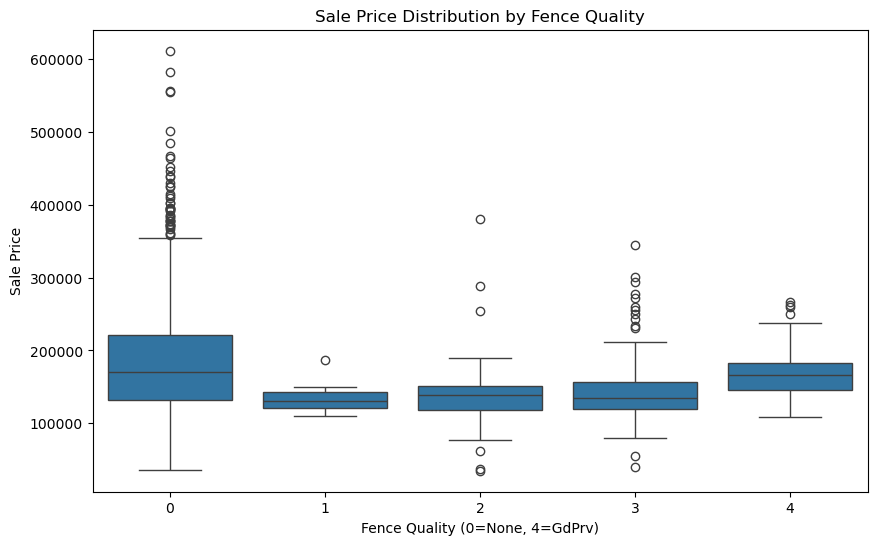

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['Fence_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Fence Quality')
plt.xlabel('Fence Quality (0=None, 4=GdPrv)')
plt.ylabel('Sale Price')
plt.show()

Experimenting with a new interaction feature `Fence_Density`

In [35]:
X['Fence_Density'] = X['Fence_Ordinal'] / X['LotArea']
correlation = X['Fence_Density'].corr(X['SalePrice'])
print(f"Correlation between Fence Density and SalePrice: {correlation:.4f}")

Correlation between Fence Density and SalePrice: -0.1920


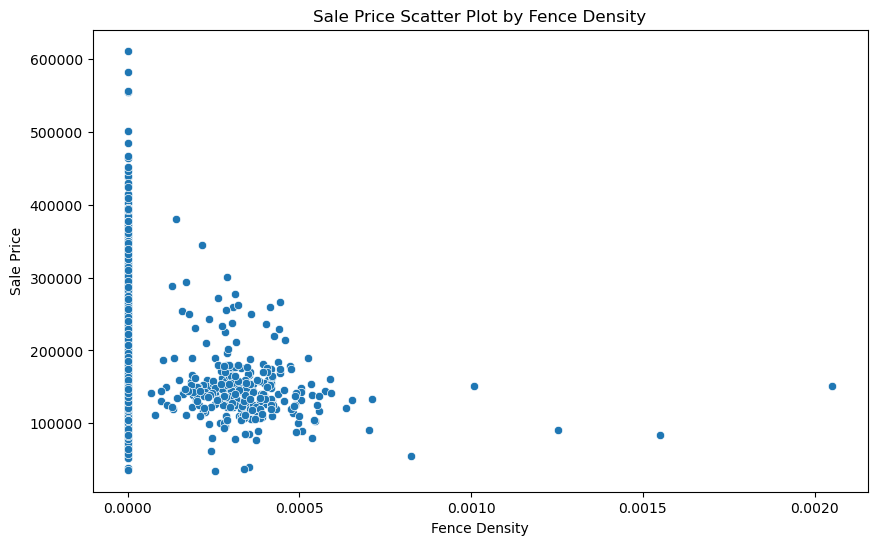

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Fence_Density'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by Fence Density')
plt.xlabel('Fence Density')
plt.ylabel('Sale Price')
plt.show()

Will drop for now might reiterate later

In [37]:
X.drop('Fence_Density', axis=1, inplace=True)

####  FireplaceQu

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace


In [38]:
X['FireplaceQu'].value_counts(dropna=False)

FireplaceQu
NaN    680
Gd     351
TA     289
Fa      32
Ex      19
Po      19
Name: count, dtype: int64

We can definetily map the `FireplaceQu` with ordinal encoding

In [39]:
fireplacequ_map = {
    'Gd': 6,
    'TA': 5,
    'Fa': 4,
    'Ex': 3,
    'Po': 1,
    'None': 0,
}

X['FireplaceQu_Ordinal'] = X['FireplaceQu'].fillna('None').map(fireplacequ_map)
housing_test['FireplaceQu_Ordinal'] = housing_test['FireplaceQu'].fillna('None').map(fireplacequ_map)
X['FireplaceQu_Ordinal']

0       0
1       5
2       5
3       6
4       5
       ..
1385    5
1386    5
1387    6
1388    0
1389    0
Name: FireplaceQu_Ordinal, Length: 1390, dtype: int64

In [40]:
X['Fireplaces'].value_counts()

Fireplaces
0    680
1    613
2     93
3      4
Name: count, dtype: int64

#### LotFrontage

In [41]:
X['LotFrontage'].value_counts(dropna=False)

LotFrontage
NaN      233
60.0     142
70.0      70
80.0      69
50.0      56
        ... 
128.0      1
149.0      1
182.0      1
152.0      1
153.0      1
Name: count, Length: 101, dtype: int64

We impute missing values by the `Neighborhood` and `LotConfig` median since very likely houses inside a neighborhood share similar architecture

In [42]:
# 1. Calculate medians on Training data
medians_lookup = X.groupby(['Neighborhood', 'LotConfig'])['LotFrontage'].median().reset_index()

# 2. Rename the column so it doesn't clash during the merge
medians_lookup.rename(columns={'LotFrontage': 'MedianFrontage'}, inplace=True)

# 3. Get a global fallback for safety
global_median = X['LotFrontage'].median()
medians_lookup

,Neighborhood,LotConfig,MedianFrontage
0,Blmngtn,Inside,43.0
1,Blueste,Inside,24.0
2,BrDale,Inside,21.0
3,BrkSide,Corner,51.0
4,BrkSide,FR2,60.0
...,...,...,...
72,Timber,Inside,85.0
73,Veenker,Corner,90.0
74,Veenker,CulDSac,31.0
75,Veenker,FR2,80.0


In [43]:
def fill_frontage(df, lookup_df, fallback):
    # Join the lookup table to the dataframe
    df = df.merge(lookup_df, on=['Neighborhood', 'LotConfig'], how='left')
    
    # Fill the NaNs in LotFrontage with the matched MedianFrontage
    df['LotFrontage'] = df['LotFrontage'].fillna(df['MedianFrontage'])
    
    # Fill any remaining NaNs with the global fallback
    df['LotFrontage'] = df['LotFrontage'].fillna(fallback)
    
    # Drop the helper column
    return df.drop(columns=['MedianFrontage'])

# Apply to both
X = fill_frontage(X, medians_lookup, global_median)
housing_test = fill_frontage(housing_test, medians_lookup, global_median)

#### GarageQual

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [44]:
# Define the mapping
garage_qu_map = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0
}

X['GarageQual_Ordinal'] = X['GarageQual'].fillna('None').map(garage_qu_map)
housing_test['GarageQual_Ordinal'] = housing_test['GarageQual'].fillna('None').map(garage_qu_map)
X['GarageQual_Ordinal']

0       3
1       3
2       3
3       3
4       3
       ..
1385    3
1386    3
1387    3
1388    3
1389    3
Name: GarageQual_Ordinal, Length: 1390, dtype: int64

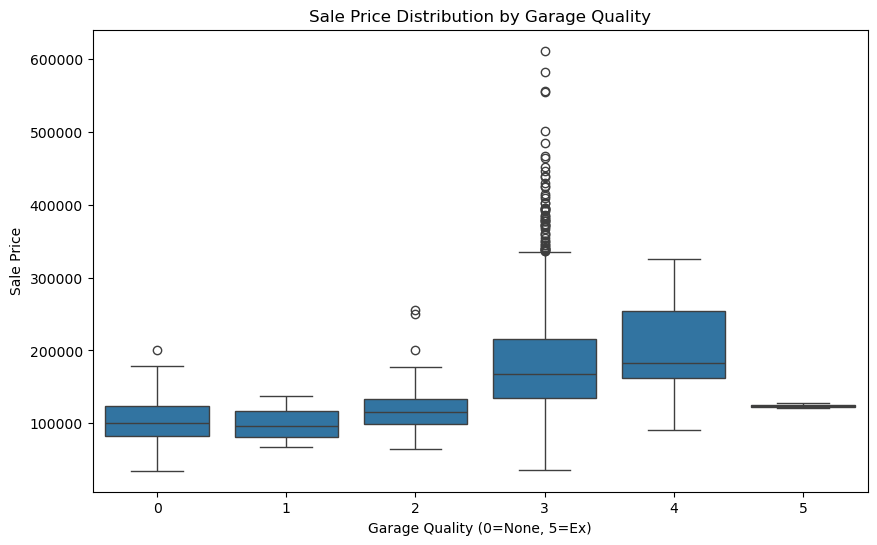

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['GarageQual_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Garage Quality')
plt.xlabel('Garage Quality (0=None, 5=Ex)')
plt.ylabel('Sale Price')
plt.show()

Drop `GarageQual`

In [46]:
X.drop('GarageQual', axis=1, inplace=True)
housing_test.drop('GarageQual', axis=1, inplace=True)

#### GarageType

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage


In [47]:
X['GarageType'].value_counts(dropna=False)

GarageType
Attchd     820
Detchd     379
BuiltIn     81
NaN         80
Basment     18
CarPort      8
2Types       4
Name: count, dtype: int64

In [48]:
X[X['GarageType'].isna()]['GarageArea'].value_counts()

GarageArea
0    80
Name: count, dtype: int64

In [49]:
mode_per_neighbor = X.groupby('Neighborhood')['GarageType'].apply(lambda x: x.mode()[0])

X['GarageType'] = X['GarageType'].fillna(X['Neighborhood'].map(mode_per_neighbor))
housing_test['GarageType'] = housing_test['GarageType'].fillna(housing_test['Neighborhood'].map(mode_per_neighbor))

X['GarageType'] = X['GarageType'].fillna('None')
housing_test['GarageType'] = housing_test['GarageType'].fillna('None')
X['GarageType'].value_counts(dropna=False)

GarageType
Attchd     842
Detchd     437
BuiltIn     81
Basment     18
CarPort      8
2Types       4
Name: count, dtype: int64

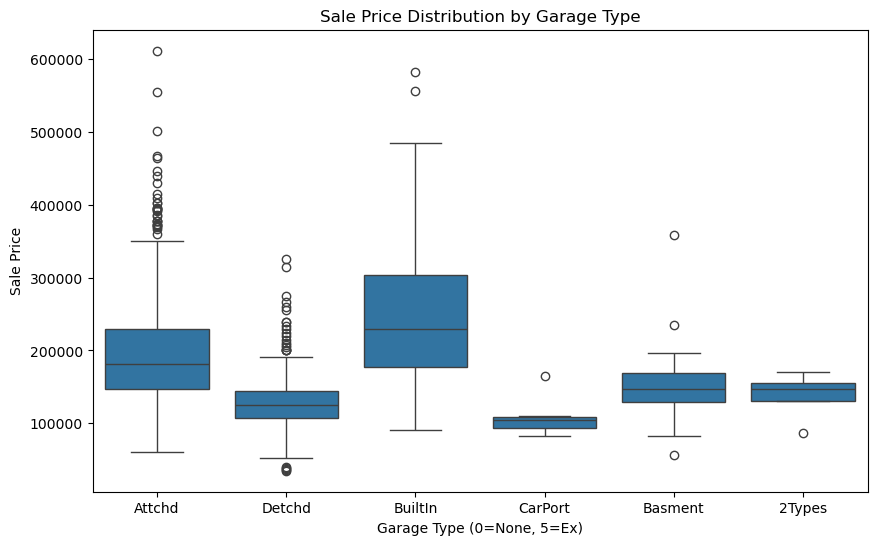

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['GarageType'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Garage Type')
plt.xlabel('Garage Type (0=None, 5=Ex)')
plt.ylabel('Sale Price')
plt.show()

#### GarageFinish

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage


In [51]:
# Define the mapping
garage_finish_map = {
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    'None': 0
}

X['GarageFinish_Ordinal'] = X['GarageFinish'].fillna('None').map(garage_finish_map)
housing_test['GarageFinish_Ordinal'] = housing_test['GarageFinish'].fillna('None').map(garage_finish_map)
X['GarageFinish_Ordinal']

0       2
1       2
2       2
3       1
4       2
       ..
1385    2
1386    1
1387    2
1388    1
1389    3
Name: GarageFinish_Ordinal, Length: 1390, dtype: int64

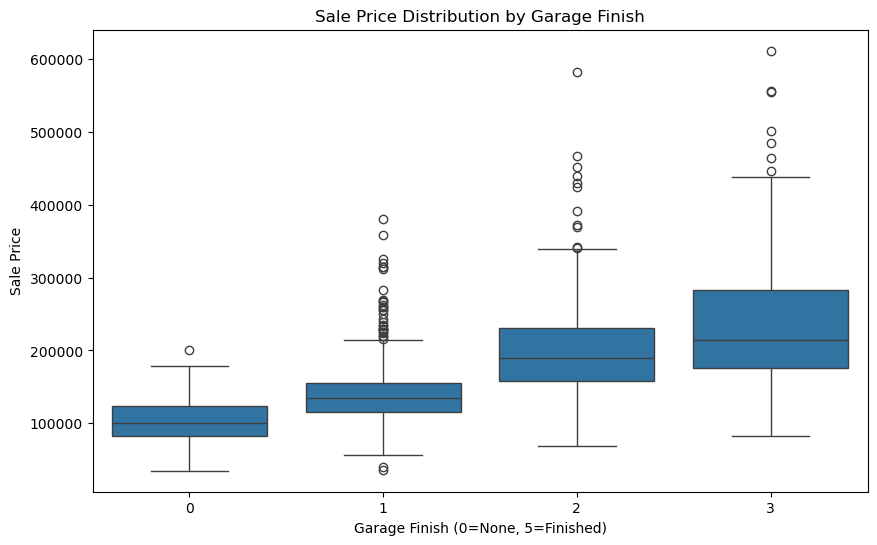

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['GarageFinish_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Garage Finish')
plt.xlabel('Garage Finish (0=None, 5=Finished)')
plt.ylabel('Sale Price')
plt.show()

In [53]:
X.drop('GarageFinish', axis=1, inplace=True)
housing_test.drop('GarageFinish', axis=1, inplace=True)

#### Next missing values

In [54]:
missing_values_df[10:20]

,Missing Values,Missing Values %
GarageCond,80,5.76
GarageYrBlt,80,5.76
BsmtExposure,37,2.66
BsmtFinType2,37,2.66
BsmtQual,36,2.59
BsmtFinType1,36,2.59
BsmtCond,36,2.59
MasVnrArea,7,0.50
Electrical,1,0.07
BldgType,0,0.00


#### GarageCond

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [55]:
# Define the mapping
garage_cond_map = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0
}

X['GarageCond_Ordinal'] = X['GarageCond'].fillna('None').map(garage_cond_map)
housing_test['GarageCond_Ordinal'] = housing_test['GarageCond'].fillna('None').map(garage_cond_map)
X['GarageCond_Ordinal']

0       3
1       3
2       3
3       3
4       3
       ..
1385    3
1386    3
1387    3
1388    3
1389    3
Name: GarageCond_Ordinal, Length: 1390, dtype: int64

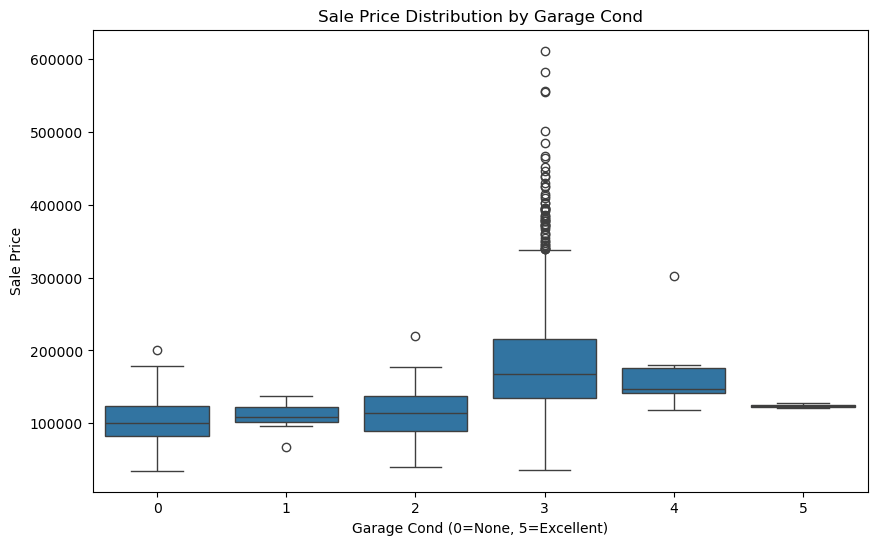

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['GarageCond_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Garage Cond')
plt.xlabel('Garage Cond (0=None, 5=Excellent)')
plt.ylabel('Sale Price')
plt.show()

In [57]:
X.drop('GarageCond', axis=1, inplace=True)
housing_test.drop('GarageCond', axis=1, inplace=True)

#### GarageYrBlt

Fill NaN `GarageYrBlt` (houses with no garage) with the year the House was built because filling with 0 would confuse the model implying the garage was built 2000 years ago!

In [58]:
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])
housing_test['GarageYrBlt'] = housing_test['GarageYrBlt'].fillna(housing_test['YearBuilt'])

In [59]:
X['GarageYrBlt'].value_counts()

GarageYrBlt
2005.0    63
2006.0    57
2004.0    54
2003.0    48
2007.0    48
          ..
1906.0     1
1875.0     1
1911.0     1
1872.0     1
1933.0     1
Name: count, Length: 100, dtype: int64

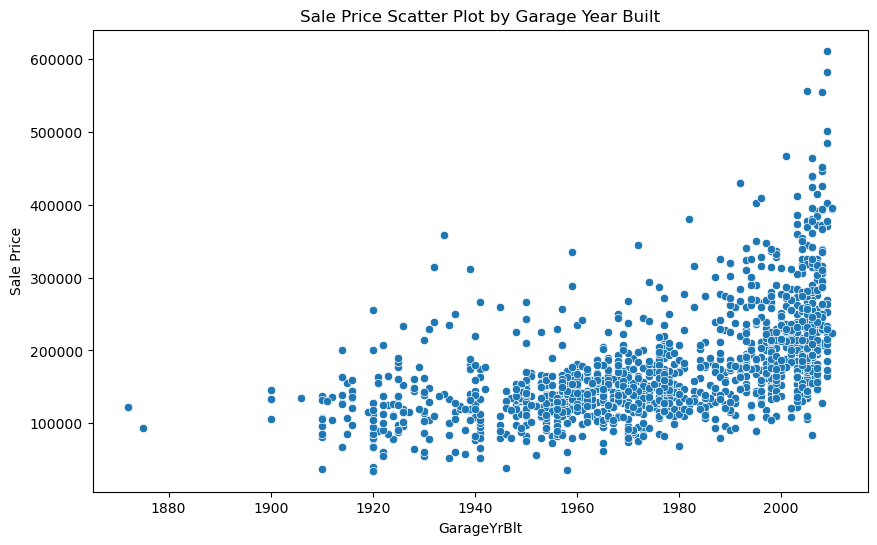

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['GarageYrBlt'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by Garage Year Built')
plt.xlabel('GarageYrBlt')
plt.ylabel('Sale Price')
plt.show()

#### BsmtExposure

In [61]:
X['BsmtExposure'].value_counts(dropna=False)

BsmtExposure
No     928
Av     212
Gd     108
Mn     105
NaN     37
Name: count, dtype: int64

Let's first handle missing data entries

In [62]:
X[(X['BsmtExposure'].isna()) & (X['TotalBsmtSF'] > 0)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,SalePrice,HasAlley,HasPool,Fence_Ordinal,FireplaceQu_Ordinal,GarageQual_Ordinal,GarageFinish_Ordinal,GarageCond_Ordinal
904,60,RL,65.0,14006,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,192500,0,False,0,5,3,2,3


In [63]:
# 1. Fill the 'Actual' missing values (houses that have basements but no exposure label)
bsmt_mode = X['BsmtExposure'].mode()[0]
mask = (X['BsmtExposure'].isnull()) & (X['TotalBsmtSF'] > 0)
X.loc[mask, 'BsmtExposure'] = bsmt_mode

In [64]:
mask = (housing_test['BsmtExposure'].isnull()) & (housing_test['TotalBsmtSF'] > 0)
housing_test.loc[mask, 'BsmtExposure'] = bsmt_mode

In [65]:
# Define the mapping
bsmt_exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}

X['BsmtExposure_Ordinal'] = X['BsmtExposure'].fillna('None').map(bsmt_exposure_map)
housing_test['BsmtExposure_Ordinal'] = housing_test['BsmtExposure'].fillna('None').map(bsmt_exposure_map)
X['BsmtExposure_Ordinal']

0       1
1       4
2       2
3       1
4       3
       ..
1385    1
1386    1
1387    1
1388    2
1389    1
Name: BsmtExposure_Ordinal, Length: 1390, dtype: int64

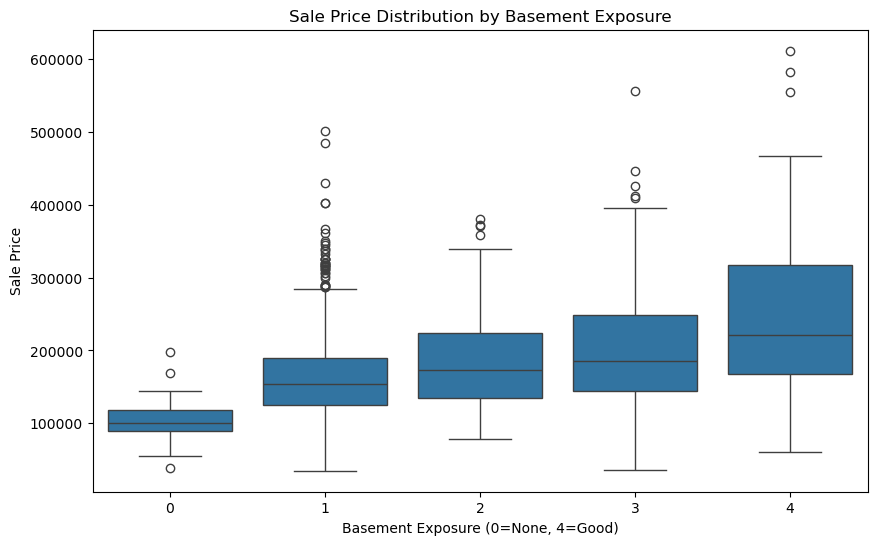

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['BsmtExposure_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Basement Exposure')
plt.xlabel('Basement Exposure (0=None, 4=Good)')
plt.ylabel('Sale Price')
plt.show()

In [67]:
X.drop('BsmtExposure', axis=1, inplace=True)
housing_test.drop('BsmtExposure', axis=1, inplace=True)

#### BsmtFinType2

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement


In [68]:
X['BsmtFinType2'].value_counts(dropna=False)

BsmtFinType2
Unf    1201
Rec      46
LwQ      45
NaN      37
BLQ      31
ALQ      17
GLQ      13
Name: count, dtype: int64

In [69]:
# 1. Fill the 'Actual' missing values (has basement, but missing FinType2 label)
# 'Unf' is the standard for a second basement area
mask = (X['BsmtFinType2'].isnull()) & (X['TotalBsmtSF'] > 0)
X.loc[mask, 'BsmtFinType2'] = 'Unf'

# Repeat for Test
mask_test = (housing_test['BsmtFinType2'].isnull()) & (housing_test['TotalBsmtSF'] > 0)
housing_test.loc[mask_test, 'BsmtFinType2'] = 'Unf'

In [70]:
# Define the mapping
bsmt_fin_type2_map = {
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    'None': 0,
}

X['BsmtFinType2_Ordinal'] = X['BsmtFinType2'].fillna('None').map(bsmt_fin_type2_map)
housing_test['BsmtFinType2_Ordinal'] = housing_test['BsmtFinType2'].fillna('None').map(bsmt_fin_type2_map)
X['BsmtFinType2_Ordinal']

0       1
1       1
2       1
3       1
4       1
       ..
1385    1
1386    3
1387    1
1388    3
1389    2
Name: BsmtFinType2_Ordinal, Length: 1390, dtype: int64

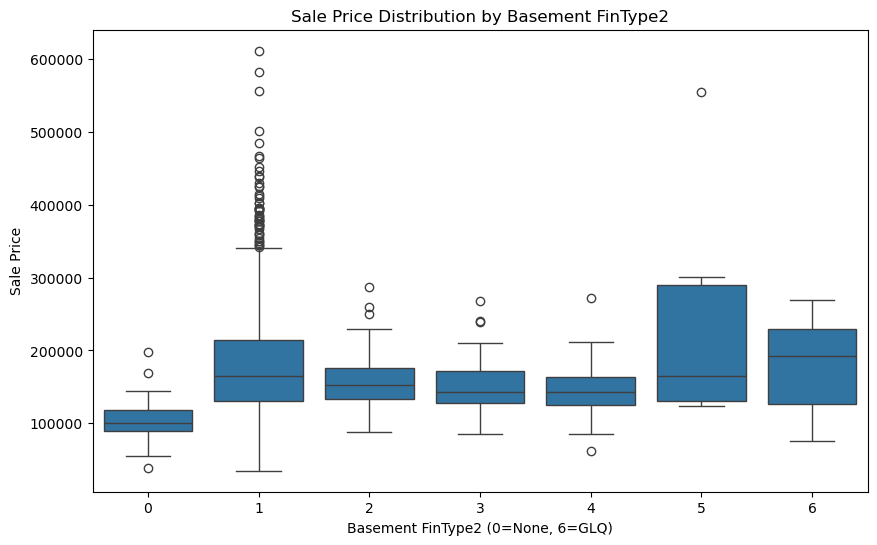

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['BsmtFinType2_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Basement FinType2')
plt.xlabel('Basement FinType2 (0=None, 6=GLQ)')
plt.ylabel('Sale Price')
plt.show()

In [72]:
X.drop('BsmtFinType2', axis=1, inplace=True)
housing_test.drop('BsmtFinType2', axis=1, inplace=True)

#### BsmtQual

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement


In [73]:
X['BsmtQual'].value_counts(dropna=False)

BsmtQual
TA     618
Gd     589
Ex     112
NaN     36
Fa      35
Name: count, dtype: int64

In [74]:
# Define the mapping
bsmt_qual_map = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0,
}

X['BsmtQual_Ordinal'] = X['BsmtQual'].fillna('None').map(bsmt_qual_map)
housing_test['BsmtQual_Ordinal'] = housing_test['BsmtQual'].fillna('None').map(bsmt_qual_map)
X['BsmtQual_Ordinal']

0       4
1       4
2       4
3       3
4       4
       ..
1385    4
1386    4
1387    3
1388    3
1389    3
Name: BsmtQual_Ordinal, Length: 1390, dtype: int64

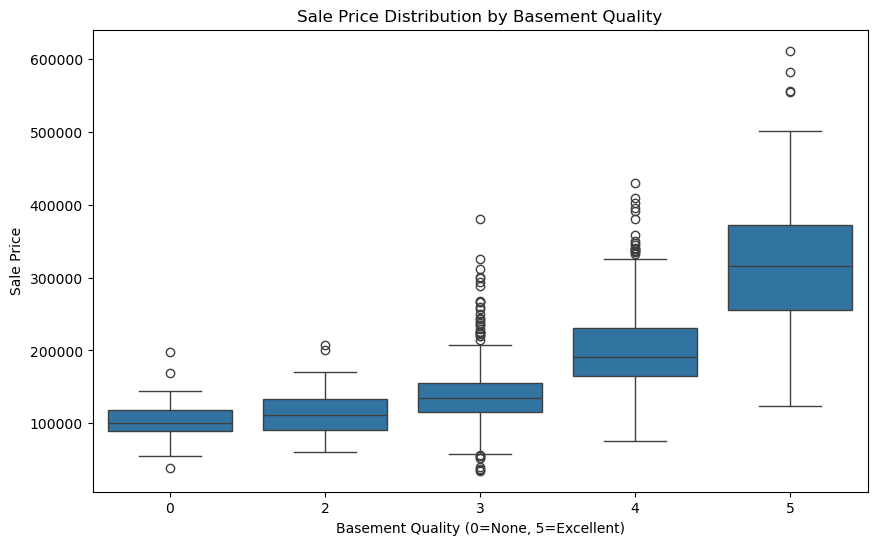

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['BsmtQual_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Basement Quality')
plt.xlabel('Basement Quality (0=None, 5=Excellent)')
plt.ylabel('Sale Price')
plt.show()

In [76]:
X.drop('BsmtQual', axis=1, inplace=True)
housing_test.drop('BsmtQual', axis=1, inplace=True)

#### BsmtCond

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement


In [77]:
X['BsmtCond'].value_counts(dropna=False)

BsmtCond
TA     1247
Gd       60
Fa       45
NaN      36
Po        2
Name: count, dtype: int64

In [78]:
# Define the mapping
bsmt_cond_map = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0,
}

X['BsmtCond_Ordinal'] = X['BsmtCond'].fillna('None').map(bsmt_cond_map)
housing_test['BsmtCond_Ordinal'] = housing_test['BsmtCond'].fillna('None').map(bsmt_cond_map)
X['BsmtCond_Ordinal']

0       3
1       3
2       3
3       4
4       3
       ..
1385    3
1386    3
1387    4
1388    3
1389    3
Name: BsmtCond_Ordinal, Length: 1390, dtype: int64

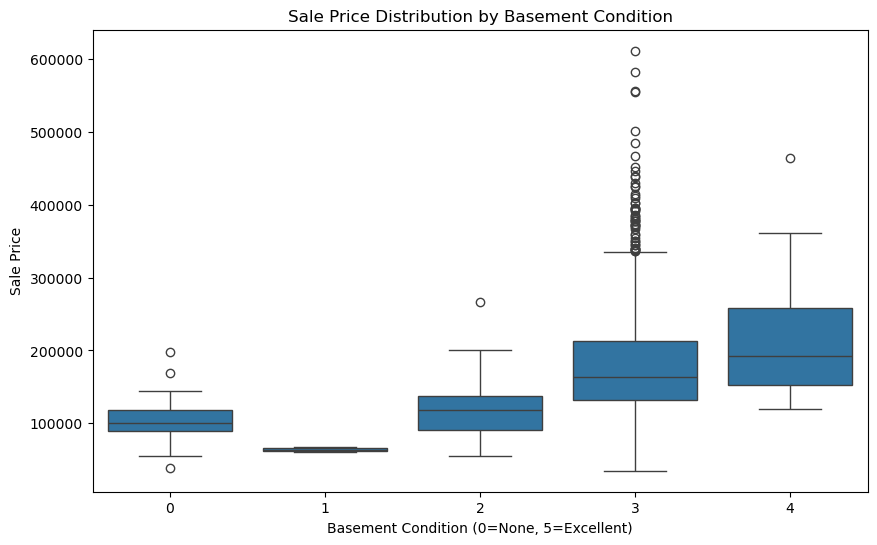

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['BsmtCond_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Basement Condition')
plt.xlabel('Basement Condition (0=None, 5=Excellent)')
plt.ylabel('Sale Price')
plt.show()

In [80]:
X.drop('BsmtCond', axis=1, inplace=True)
housing_test.drop('BsmtCond', axis=1, inplace=True)

#### BsmtFinType1

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement


In [81]:
X['BsmtFinType1'].value_counts(dropna=False)

BsmtFinType1
Unf    415
GLQ    394
ALQ    210
BLQ    140
Rec    125
LwQ     70
NaN     36
Name: count, dtype: int64

In [82]:
# 1. Fill the 'Actual' missing values (has basement, but missing FinType2 label)
# 'Unf' is the standard for a second basement area
mask = (X['BsmtFinType1'].isnull()) & (X['TotalBsmtSF'] > 0)
X.loc[mask, 'BsmtFinType1'] = 'Unf'

# Repeat for Test
mask_test = (housing_test['BsmtFinType1'].isnull()) & (housing_test['TotalBsmtSF'] > 0)
housing_test.loc[mask_test, 'BsmtFinType1'] = 'Unf'

In [83]:
# Define the mapping
bsmt_fin_type1_map = {
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    'None': 0,
}

X['BsmtFinType1_Ordinal'] = X['BsmtFinType1'].fillna('None').map(bsmt_fin_type1_map)
housing_test['BsmtFinType1_Ordinal'] = housing_test['BsmtFinType1'].fillna('None').map(bsmt_fin_type1_map)
X['BsmtFinType1_Ordinal']

0       6
1       5
2       6
3       5
4       6
       ..
1385    1
1386    5
1387    6
1388    6
1389    4
Name: BsmtFinType1_Ordinal, Length: 1390, dtype: int64

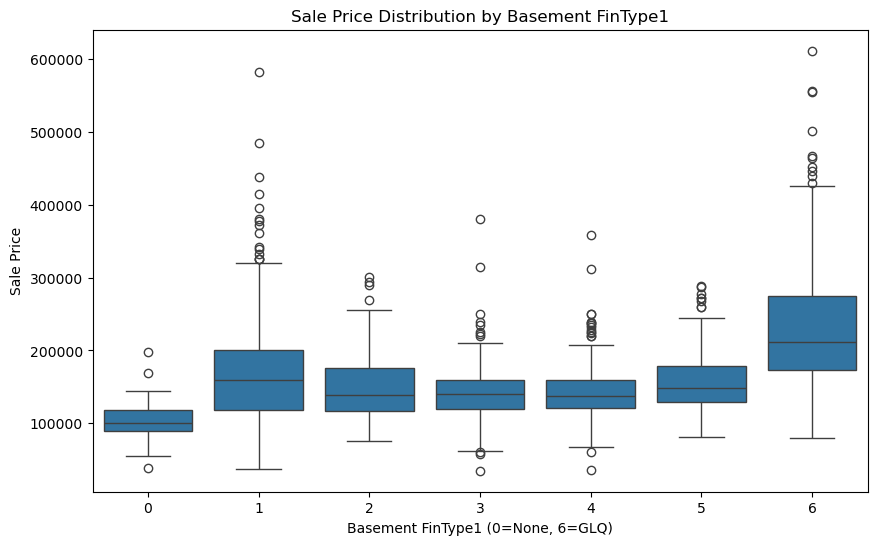

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=X['BsmtFinType1_Ordinal'], y=X['SalePrice'])
plt.title('Sale Price Distribution by Basement FinType1')
plt.xlabel('Basement FinType1 (0=None, 6=GLQ)')
plt.ylabel('Sale Price')
plt.show()

In [85]:
X.drop('BsmtFinType1', axis=1, inplace=True)
housing_test.drop('BsmtFinType1', axis=1, inplace=True)

#### MasVnrArea

In [86]:
X['MasVnrArea'].value_counts(dropna=False)

MasVnrArea
0.0      819
72.0       8
108.0      8
180.0      8
16.0       7
        ... 
426.0      1
96.0       1
438.0      1
194.0      1
119.0      1
Name: count, Length: 315, dtype: int64

In [87]:
X['MasVnrArea'] = X.groupby('MasVnrType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X['MasVnrArea']

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1385      0.0
1386    119.0
1387      0.0
1388      0.0
1389      0.0
Name: MasVnrArea, Length: 1390, dtype: float64

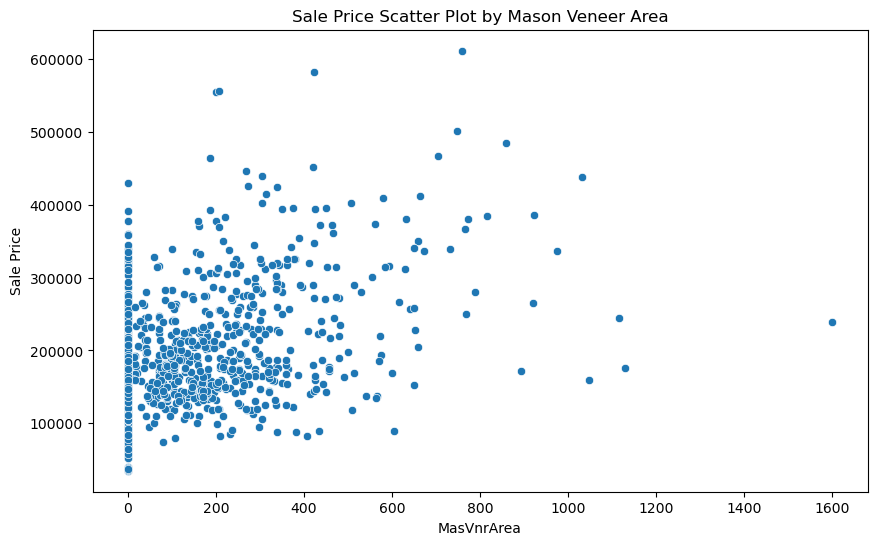

In [88]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['MasVnrArea'], y=X['SalePrice'])
plt.title('Sale Price Scatter Plot by Mason Veneer Area')
plt.xlabel('MasVnrArea')
plt.ylabel('Sale Price')
plt.show()

#### Electrical

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed


In [89]:
X['Electrical'].value_counts(dropna=False)

Electrical
SBrkr    1266
FuseA      92
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: count, dtype: int64

In [90]:
X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode())

### Treat categorical features

In [91]:
X['MSSubClass'] = X['MSSubClass'].astype(str)
housing_test['MSSubClass'] = housing_test['MSSubClass'].astype(str)

### Target Encoding

custom `MEstimateEncoder` to target encode features

In [92]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MyMEstimateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col, m=1.0):
        self.col = col
        self.m = m # 'm' is the smoothing parameter
        self.mapped_values = {}

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # 1. Calculate global mean
        self.global_mean = y.mean()
        
        # 2. Calculate category means and counts
        df = pd.DataFrame({'col': X[self.col], 'target': y})
        stats = df.groupby('col')['target'].agg(['count', 'mean'])
        
        # 3. Apply M-Estimate Formula
        # Formula: (count * mean + m * global_mean) / (count + m)
        encoded_means = (stats['count'] * stats['mean'] + self.m * self.global_mean) / (stats['count'] + self.m)
        
        # 4. Store mapping
        self.mapped_values = encoded_means.to_dict()
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        
        # Map the calculated values to the column
        X[self.col] = X[self.col].map(self.mapped_values)
        
        # 5. Handle Unknown/New categories in test set
        # Fill missing values (unseen in training) with the global mean
        X[self.col] = X[self.col].fillna(self.global_mean)
        
        return X[[self.col]] # Return as a DataFrame column


#### High cardinality features

In [93]:
high_cardinality_features = [colname for colname in X.select_dtypes(exclude=['number']).columns if len(X[colname].unique()) >= 10]
high_cardinality_features_n_unique = [X[colname].nunique() for colname in high_cardinality_features]
high_cardinality_features_df = pd.DataFrame({'High Cardinality features n_unique': high_cardinality_features_n_unique}, index=high_cardinality_features)
high_cardinality_features_df

,High Cardinality features n_unique
MSSubClass,15
Neighborhood,25
Exterior1st,15
Exterior2nd,16


#### MSSubClass

In [94]:
X['MSSubClass'].value_counts()

MSSubClass
20     511
60     279
50     139
120     87
30      67
160     62
70      56
80      54
90      50
190     27
85      20
75      13
45      12
180     10
40       3
Name: count, dtype: int64

1% instances

In [95]:
X.shape[0] * 1 / 100

13.9

Bucket each category with less than ~1% (15) instances into the same `Other` bucket

In [96]:
import math
threshold = math.ceil(X.shape[0] * 1 / 100)
counts = X['MSSubClass'].value_counts()
repl = counts[counts <= threshold].index

X['MSSubClass'] = X['MSSubClass'].replace(repl, 'Other')
housing_test['MSSubClass'] = housing_test['MSSubClass'].replace(repl, 'Other')

In [97]:
X['MSSubClass'].value_counts()

MSSubClass
20       511
60       279
50       139
120       87
30        67
160       62
70        56
80        54
90        50
Other     38
190       27
85        20
Name: count, dtype: int64

#### Neighborhood

In [98]:
encoder = MyMEstimateEncoder(col='Neighborhood', m=10.0)
X['Neighborhood_encoded'] = encoder.fit_transform(X, X['SalePrice'])
housing_test['Neighborhood_encoded'] = encoder.transform(housing_test)

X.drop('Neighborhood', axis=1, inplace=True)
housing_test.drop('Neighborhood', axis=1, inplace=True)

X['Neighborhood_encoded']

0       196696.985477
1       200907.583813
2       196696.985477
3       204208.573268
4       277146.949484
            ...      
1385    190040.154589
1386    186226.666788
1387    204208.573268
1388    145918.099023
1389    129942.873107
Name: Neighborhood_encoded, Length: 1390, dtype: float64

#### Exterior1st

In [99]:
encoder = MyMEstimateEncoder(col='Exterior1st', m=10.0)
X['Exterior1st_encoded'] = encoder.fit_transform(X, X['SalePrice'])
housing_test['Exterior1st_encoded'] = encoder.transform(housing_test)

X.drop('Exterior1st', axis=1, inplace=True)
housing_test.drop('Exterior1st', axis=1, inplace=True)


#### Exterior2nd

In [100]:
encoder = MyMEstimateEncoder(col='Exterior2nd', m=10.0)
X['Exterior2nd_encoded'] = encoder.fit_transform(X, X['SalePrice'])
housing_test['Exterior2nd_encoded'] = encoder.transform(housing_test)

X.drop('Exterior2nd', axis=1, inplace=True)
housing_test.drop('Exterior2nd', axis=1, inplace=True)


### Feature Engineering

In [101]:
from sklearn.compose import make_column_transformer
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

def score_model(model:BaseEstimator, X: pd.DataFrame, y, new_feature:str=None, drop_features=[], scoring='neg_root_mean_squared_error', cv=3, scores_dict={}):
    drop_features = set(drop_features)
    # Separate numerical and categorical features
    num_features = X.select_dtypes(include=['number']).columns.tolist()
    cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

    # Remove drop_features
    num_features = list(set(num_features).difference(drop_features))
    cat_features = list(set(cat_features).difference(drop_features))

    # Create pipelines
    num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
    cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore' ,sparse_output=False))

    # Setup preprocessing pipeline
    preprocess = make_column_transformer(
        (num_pipeline, num_features),
        (cat_pipeline, cat_features),
        remainder='drop')
    clf = make_pipeline(preprocess, clone(model))

    # Score model
    scores = -cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    print(f"Score with {new_feature} {'feature' if new_feature else ''}: {scores.mean()} +/- {scores.std()}")

    if new_feature:
        scores_dict[new_feature] = [scores.mean(), scores.std()]
    return clf

In [102]:
from sklearn.model_selection import train_test_split

y = X.pop('SalePrice')

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

new_feature_scores_rf = {}
new_feature_scores_lin = {}

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, new_feature='Original', scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='Original', scores_dict=new_feature_scores_lin)

Score with Original feature: 24118.393663541116 +/- 913.5302888207077
Score with Original feature: 23084.263813523175 +/- 1607.2778481447012


#### Fence_Density

In [104]:
X['Fence_Density'] = X['Fence_Ordinal'] / X['LotArea']
housing_test['Fence_Density'] = housing_test['Fence_Ordinal'] / housing_test['LotArea']

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, 
                     cv=5,new_feature='Fence_Density', scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='Fence_Density', scores_dict=new_feature_scores_lin)

X.drop('Fence_Density', axis=1, inplace=True)
housing_test.drop('Fence_Density', axis=1, inplace=True)

Score with Fence_Density feature: 24260.498229139594 +/- 1010.6598620875461
Score with Fence_Density feature: 23115.11706257266 +/- 1642.6142258470495


#### FireplaceScore

In [105]:
X['Fireplace_Score'] = X['Fireplaces'] * X['FireplaceQu_Ordinal']
housing_test['Fireplace_Score'] = housing_test['Fireplaces'] * housing_test['FireplaceQu_Ordinal']

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, 
                     cv=5, new_feature='Fireplace_Score',
                     scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='Fireplace_Score', scores_dict=new_feature_scores_lin)

X.drop('Fireplace_Score', axis=1, inplace=True)
housing_test.drop('Fireplace_Score', axis=1, inplace=True)

Score with Fireplace_Score feature: 24109.47069267781 +/- 793.1999871689743
Score with Fireplace_Score feature: 23107.233412225607 +/- 1570.5361173791403


#### BasementScore

$BasementScore = (FinType1\_Ord \times BsmtFinSF1) + (FinType2\_Ord \times BsmtFinSF2)$

In [106]:
X['BasementScore'] = (X['BsmtFinType1_Ordinal'] * X['BsmtFinSF1']) + \
    (X['BsmtFinType2_Ordinal'] * X['BsmtFinSF2'])
housing_test['BasementScore'] = (housing_test['BsmtFinType1_Ordinal'] * housing_test['BsmtFinSF1']) + \
    (housing_test['BsmtFinType2_Ordinal'] * housing_test['BsmtFinSF2'])

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5,
                     new_feature='BasementScore', scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='BasementScore', scores_dict=new_feature_scores_lin)


Score with BasementScore feature: 24226.954483481328 +/- 1089.6194627336386
Score with BasementScore feature: 22658.350534956397 +/- 1469.9934359086374


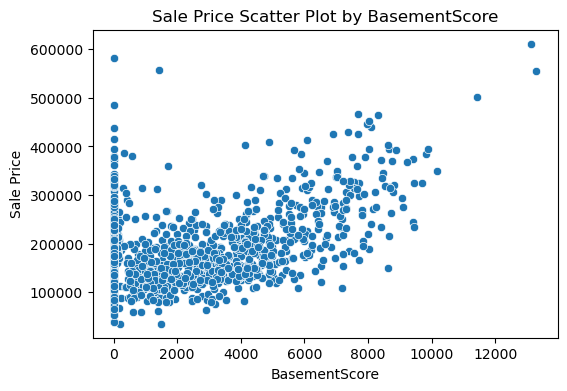

In [107]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X['BasementScore'], y=y)
plt.title('Sale Price Scatter Plot by BasementScore')
plt.xlabel('BasementScore')
plt.ylabel('Sale Price')
plt.show()

In [108]:
X.drop('BasementScore', axis=1, inplace=True)
housing_test.drop('BasementScore', axis=1, inplace=True)

#### TotalSquareFootage

`TotalSquareFootage` = `1stFlrSF` + `2ndFlrSF` + `TotalBsmtSF`

In [109]:
X['TotalSquareFootage'] = X['1stFlrSF'] + X['2ndFlrSF']
housing_test['TotalSquareFootage'] = housing_test['1stFlrSF'] + housing_test['2ndFlrSF']

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     new_feature='TotalSquareFootage',
                     drop_features=['1stFlrSF', '2ndFlrSF'],
                     scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='TotalSquareFootage', scores_dict=new_feature_scores_lin)


Score with TotalSquareFootage feature: 24279.028761051733 +/- 1237.2821207684572
Score with TotalSquareFootage feature: 23084.26381352316 +/- 1607.2778481447085


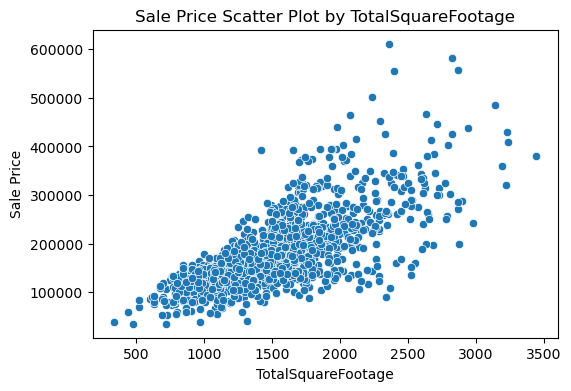

In [110]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X['TotalSquareFootage'], y=y)
plt.title('Sale Price Scatter Plot by TotalSquareFootage')
plt.xlabel('TotalSquareFootage')
plt.ylabel('Sale Price')
plt.show()

In [111]:
X.drop('TotalSquareFootage', axis=1, inplace=True)
housing_test.drop('TotalSquareFootage', axis=1, inplace=True)

#### TotalBathrooms

`TotalBathrooms` = `Fullbath` + 0.5 * `HalfBath` + `BsmtFullBath` + 0.5 * `BsmtHalfBath`

In [112]:
X['TotalBathrooms'] = X['FullBath'] + 0.5 * X['HalfBath'] + \
      X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']

housing_test['TotalBathrooms'] = housing_test['FullBath'] + 0.5 * housing_test['HalfBath'] + \
      housing_test['BsmtFullBath'] + 0.5 * housing_test['BsmtHalfBath']

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     new_feature='TotalBathrooms',
                     scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='TotalBathrooms', scores_dict=new_feature_scores_lin)


Score with TotalBathrooms feature: 24369.447041292085 +/- 940.6977560588368
Score with TotalBathrooms feature: 23084.263813523172 +/- 1607.2778481447058


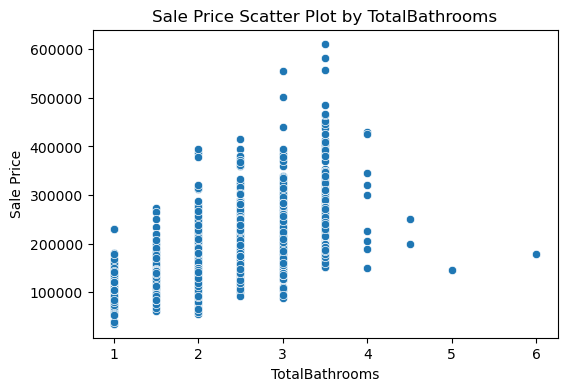

In [113]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X['TotalBathrooms'], y=y)
plt.title('Sale Price Scatter Plot by TotalBathrooms')
plt.xlabel('TotalBathrooms')
plt.ylabel('Sale Price')
plt.show()

In [114]:
X.drop('TotalBathrooms', axis=1, inplace=True)
housing_test.drop('TotalBathrooms', axis=1, inplace=True)

#### PercentSecondFloor

$PercentSecondFloor = \frac{2ndFlrSF}{TotalSquareFootage}$

In [115]:
X['2ndFlrPct'] = X['2ndFlrSF'] / (X['1stFlrSF'] + X['2ndFlrSF'] + 1e-6) # add small constant to avoid div by zero
housing_test['2ndFlrPct'] = housing_test['2ndFlrSF'] / (housing_test['1stFlrSF'] + housing_test['2ndFlrSF'] + 1e-6) # add small constant to avoid div by zero

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     new_feature='2ndFlrPct',
                     scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='2ndFlrPct', scores_dict=new_feature_scores_lin)


Score with 2ndFlrPct feature: 24375.954500056316 +/- 1199.237654287415
Score with 2ndFlrPct feature: 23104.022160252458 +/- 1584.067321728845


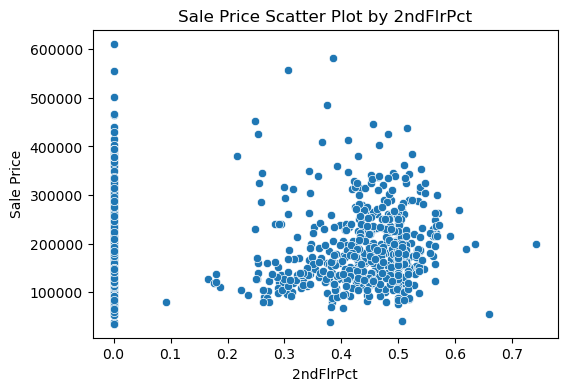

In [116]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X['2ndFlrPct'], y=y)
plt.title('Sale Price Scatter Plot by 2ndFlrPct')
plt.xlabel('2ndFlrPct')
plt.ylabel('Sale Price')
plt.show()

In [117]:
X.drop('2ndFlrPct', axis=1, inplace=True)
housing_test.drop('2ndFlrPct', axis=1, inplace=True)

#### Season

In [118]:
def mo_to_season(x):
    if x in (12,1,2):
        return 'Winter'
    elif x in (3,4,5):
        return 'Spring'
    elif x in (6,7,8):
        return 'Summer'
    else:
        return 'Autumn'

X['SeasonSold'] = X['MoSold'].transform(mo_to_season)
housing_test['SeasonSold'] = housing_test['MoSold'].transform(mo_to_season)

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     new_feature='SeasonSold', drop_features=['MoSold'],
                     scores_dict=new_feature_scores_rf)
lin_reg = score_model(LinearRegression(), X, y, cv=5, new_feature='SeasonSold', scores_dict=new_feature_scores_lin,
                      drop_features=['MoSold'])

X.drop('SeasonSold', axis=1, inplace=True)
housing_test.drop('SeasonSold', axis=1, inplace=True)

Score with SeasonSold feature: 24212.252897497856 +/- 1198.805960446283
Score with SeasonSold feature: 23092.47824172772 +/- 1657.284326288854


#### New Feature Performance

In [119]:
new_features_rf_mean = [x[0] for x in new_feature_scores_rf.values()]
new_features_rf_std = [x[1] for x in new_feature_scores_rf.values()]

new_features_scores_rf_df = pd.DataFrame({'Mean': new_features_rf_mean, 'Std': new_features_rf_std}, index=new_feature_scores_rf.keys())
new_features_scores_rf_df.sort_values(by='Mean')

,Mean,Std
Fireplace_Score,24109.470693,793.199987
Original,24118.393664,913.530289
SeasonSold,24212.252897,1198.805960
BasementScore,24226.954483,1089.619463
Fence_Density,24260.498229,1010.659862
TotalSquareFootage,24279.028761,1237.282121
TotalBathrooms,24369.447041,940.697756
2ndFlrPct,24375.954500,1199.237654


In [120]:
new_features_lin_mean = [x[0] for x in new_feature_scores_lin.values()]
new_features_lin_std = [x[1] for x in new_feature_scores_lin.values()]

new_features_scores_lin_df = pd.DataFrame({'Mean': new_features_lin_mean, 'Std': new_features_lin_std}, index=new_feature_scores_lin.keys())
new_features_scores_lin_df.sort_values(by='Mean')

,Mean,Std
BasementScore,22658.350535,1469.993436
TotalSquareFootage,23084.263814,1607.277848
TotalBathrooms,23084.263814,1607.277848
Original,23084.263814,1607.277848
SeasonSold,23092.478242,1657.284326
2ndFlrPct,23104.022160,1584.067322
Fireplace_Score,23107.233412,1570.536117
Fence_Density,23115.117063,1642.614226


In [121]:
# TotalBathrooms
X['TotalBathrooms'] = X['FullBath'] + 0.5 * X['HalfBath'] + \
      X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
# SeasonSold
X['SeasonSold'] = X['MoSold'].transform(mo_to_season)
# BasementScore
X['BasementScore'] = (X['BsmtFinType1_Ordinal'] * X['BsmtFinSF1']) + \
    (X['BsmtFinType2_Ordinal'] * X['BsmtFinSF2'])

X['Fireplace_Score'] = X['Fireplaces'] * X['FireplaceQu_Ordinal']

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     drop_features=['MoSold'])


Score with None : 24027.640904460663 +/- 1246.0767668069363


For test also

In [122]:
# TotalBathrooms
housing_test['TotalBathrooms'] = housing_test['FullBath'] + 0.5 * housing_test['HalfBath'] + \
      housing_test['BsmtFullBath'] + 0.5 * housing_test['BsmtHalfBath']
# SeasonSold
housing_test['SeasonSold'] = housing_test['MoSold'].transform(mo_to_season)
# BasementScore
housing_test['BasementScore'] = (housing_test['BsmtFinType1_Ordinal'] * housing_test['BsmtFinSF1']) + \
    (housing_test['BsmtFinType2_Ordinal'] * housing_test['BsmtFinSF2'])

housing_test['Fireplace_Score'] = housing_test['Fireplaces'] * housing_test['FireplaceQu_Ordinal']


Dropping features with high skewed distributions

In [123]:
rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     drop_features=['MoSold', 'PoolArea', 'MiscVal'])


Score with None : 23878.580808577623 +/- 1224.233026204487


### Log to skewed distributions

--- Top 10 Most Skewed Features ---
MiscVal                 28.706148
PoolArea                21.744682
3SsnPorch               11.186360
LowQualFinSF             9.564897
KitchenAbvGr             4.484987
BsmtFinSF2               4.405294
BsmtHalfBath             4.185158
ScreenPorch              4.172571
HasAlley                 3.541290
BsmtFinType2_Ordinal     3.395641
dtype: float64


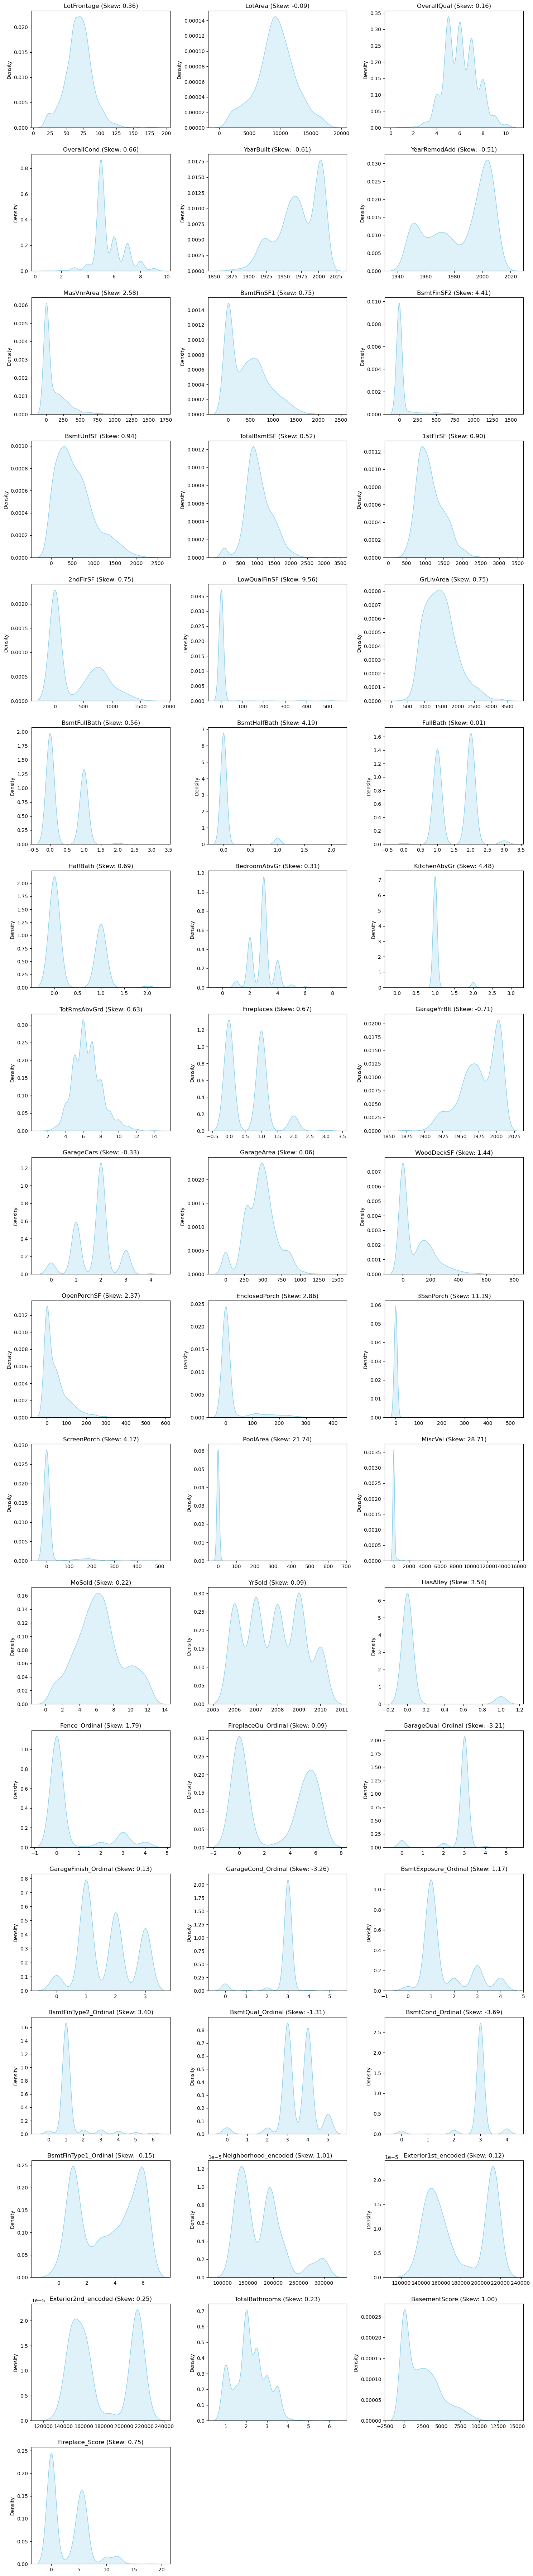

In [124]:
from scipy.stats import skew

def plot_numerical_distributions(df):
    # 1. Select only numerical columns (excluding ID and Target if needed)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Optional: Remove the target variable or ID if they are in df
    # numeric_cols = [c for c in numeric_cols if c not in ['SalePrice', 'Id']]
    
    # 2. Calculate skewness for all features and sort
    skew_values = df[numeric_cols].skew().sort_values(ascending=False)
    print("--- Top 10 Most Skewed Features ---")
    print(skew_values.head(10))
    
    # 3. Setup the plotting grid
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot KDE
        sns.kdeplot(df[col], fill=True, color='skyblue')
        
        # Calculate skewness for the title
        s = df[col].skew()
        plt.title(f"{col} (Skew: {s:.2f})")
        plt.xlabel("")
        plt.ylabel("Density")
        
    plt.tight_layout()
    plt.show()

# Run the function
plot_numerical_distributions(X)

In [125]:
# 1. Determine which features to log-transform using ONLY X_train
threshold = 0.75
numeric_feats = X.select_dtypes(include=[np.number]).columns

# Filter out discrete counts (optional but recommended)
continuous_feats = [col for col in numeric_feats if X[col].nunique() > 25]

skewed_features = [col for col in continuous_feats if abs(X[col].skew()) > threshold]

X_log = X.copy()
housing_test_log = housing_test.copy()

# 2. Apply to both sets
for col in skewed_features:
    X_log[col] = np.log1p(X_log[col])
    housing_test_log[col] = np.log1p(housing_test_log[col])

In [126]:
from sklearn.linear_model import Lasso
rf_reg = score_model(RandomForestRegressor(n_estimators=100), X_log, y, cv=5, 
                     drop_features=['MoSold'])
lin_reg = score_model(LinearRegression(), X_log, y, cv=5, 
                     drop_features=['MoSold'])
lasso_reg = score_model(Lasso(), X_log, y, cv=5, 
                     drop_features=['MoSold'])


Score with None : 23961.499084527524 +/- 1048.5007180302507
Score with None : 24401.86808199167 +/- 1568.761671217292


c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+11, tolerance: 6.230e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e+11, tolerance: 5.916e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Score with None : 24349.927585644124 +/- 1566.91759609263


c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+11, tolerance: 6.255e+08
  model = cd_fast.enet_coordinate_descent(


#### Target Skewness

We might consider applying a log-transform to the target feature as well since it is heavily skewed

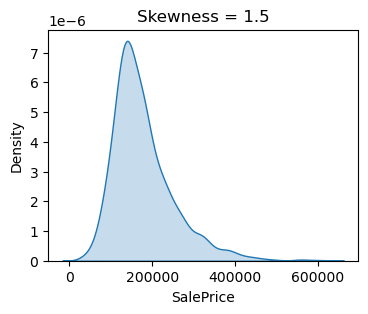

In [127]:
plt.figure(figsize=(4,3))
sns.kdeplot(y, fill=True);
plt.title(f"Skewness = {y.skew().round(2)}");

### Model Selection

Both Random Forest and LinearRegression seem to have about the same RMSE but RandomForest has a bit better std

In [128]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X, y, cv=5, 
                     drop_features=['MoSold'])
gb_reg = score_model(GradientBoostingRegressor(n_estimators=100), X, y, cv=5, 
                     drop_features=['MoSold'])
xgb_reg = score_model(XGBRegressor(n_estimators=100), X, y, cv=5, 
                     drop_features=['MoSold'])


Score with None : 23885.34749697738 +/- 868.3917351816945
Score with None : 21871.65462670975 +/- 1360.1496910656022
Score with None : 23434.972265625 +/- 1002.2050923338569


Log transform has little effect on Ensembles of trees and trees in general

In [129]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor

rf_reg = score_model(RandomForestRegressor(n_estimators=100), X_log, y, cv=5, 
                     drop_features=['MoSold'])
gb_reg = score_model(GradientBoostingRegressor(n_estimators=100), X_log, y, cv=5, 
                     drop_features=['MoSold'])
xgb_reg = score_model(XGBRegressor(n_estimators=100), X_log, y, cv=5, 
                     drop_features=['MoSold'])


Score with None : 24008.059698284895 +/- 1199.3910941714382
Score with None : 21769.57886421526 +/- 1375.5599524062052
Score with None : 23434.972265625 +/- 1002.2050923338569


In [130]:
gb_reg.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['BsmtUnfSF', 'GarageQual_Ordinal',
                                     'BedroomAbvGr', 'GrLivArea', 'BsmtFinSF1',
                                     'PoolArea', 'GarageCond_Ordinal',
                                     'LowQualFinSF', '1stFlrSF', 'BsmtFullBath',
                                     '2ndFlrSF', 'LotArea', 'BsmtFinType2_Ordinal',
                                     'HasAlle...
                                    ['LotShape', 'RoofStyle', 'Foundation',
                                     'PoolQC', 'Condition2', 'MasVnrType',
         

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 1. Parameter distribution for Gradient Boosting
gb_params = {
    'gradientboostingregressor__n_estimators': randint(100, 500),
    'gradientboostingregressor__learning_rate': uniform(0.01, 0.1),
    'gradientboostingregressor__max_depth': randint(3, 6),
    'gradientboostingregressor__subsample': uniform(0.7, 0.3) # 0.7 to 1.0
}

# 2. Parameter distribution for XGBoost
xgb_params = {
    'xgbregressor__n_estimators': randint(100, 500),
    'xgbregressor__learning_rate': uniform(0.01, 0.1),
    'xgbregressor__max_depth': randint(3, 6),
    'xgbregressor__colsample_bytree': uniform(0.7, 0.3)
}

# Note: You should run these on your preprocessed X_log
# Use RandomizedSearchCV(model, param_distributions=gb_params, n_iter=20, cv=5...)
gb_search = RandomizedSearchCV(gb_reg, param_distributions=gb_params, n_iter=20, cv=5, scoring='neg_root_mean_squared_error')
xgb_search = RandomizedSearchCV(xgb_reg, param_distributions=xgb_params, n_iter=20, cv=5, scoring='neg_root_mean_squared_error')

gb_search.fit(X_log, y)
xgb_search.fit(X_log, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['BsmtUnfSF',
                                                                                'GarageQual_Ordinal',
                                                                                'BedroomAbvGr',
                                                                                'GrLivArea',
                                                                                'BsmtFinSF1',
                                                                                'PoolArea',
                                                                                'GarageCond_Ordinal',
                                                                                'LowQualFinSF',
                                                                                '1stFlr...
                                        'xgbregressor__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E8C886700>,
                                        'xgbregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016E8D208910>,
                                        'xgbregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016E8A81D430>},
                   scoring='neg_root_mean_squared_error')

In [156]:
-gb_search.best_score_, -xgb_search.best_score_

(np.float64(20766.797597678837), np.float64(21076.56796875))

In [133]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

# Use the best_estimator_ found by your search
best_gb = gb_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# The Ensemble
ensemble = VotingRegressor(estimators=[
    ('gb', best_gb),
    ('xgb', best_xgb)
])

# Final Evaluation
-cross_val_score(ensemble, X_log, y, cv=5, scoring='neg_root_mean_squared_error').mean()

np.float64(20511.24216186905)

In [134]:
lasso_reg = score_model(Lasso(), X_log, y, drop_features=['MoSold'], cv=5)

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+11, tolerance: 6.230e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e+11, tolerance: 5.916e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Score with None : 24349.927585644124 +/- 1566.91759609263


c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+11, tolerance: 6.255e+08
  model = cd_fast.enet_coordinate_descent(


In [135]:
ensemble_w_lasso = VotingRegressor(estimators=[
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('lasso', lasso_reg),
])

# Final Evaluation
-cross_val_score(ensemble_w_lasso, X_log, y, cv=5, scoring='neg_root_mean_squared_error').mean()

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+11, tolerance: 6.230e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e+11, tolerance: 5.916e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

np.float64(20285.23080510864)

In [136]:
from sklearn.ensemble import StackingRegressor

stacking_ensemble_w_lasso = StackingRegressor(estimators=[
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('lasso', lasso_reg),
])

# Final Evaluation
-cross_val_score(stacking_ensemble_w_lasso, X_log, y, cv=5, scoring='neg_root_mean_squared_error').mean()

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+11, tolerance: 6.230e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+11, tolerance: 4.773e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

np.float64(20389.340645109)

In [137]:
ensemble_w_lasso.fit(X_log, y)

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e+11, tolerance: 7.673e+08
  model = cd_fast.enet_coordinate_descent(


VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['BsmtUnfSF',
                                                                                'GarageQual_Ordinal',
                                                                                'BedroomAbvGr',
                                                                                'GrLivArea',
                                                                                'BsmtFinSF1',
                                                                                'PoolArea',
                                                                                'GarageCond_Ordinal',
                                                                                'LowQualFinSF',
                                                                                '1stFlr...
                                                                                'Condition2',
                                                                                'MasVnrType',
                                                                                'LotConfig',
                                                                                'LandSlope',
                                                                                'Electrical',
                                                                                'SaleType',
                                                                                'PavedDrive',
                                                                                'FireplaceQu',
                                                                                'SeasonSold',
                                                                                'Fence',
                                                                                'BldgType',
                                                                                'GarageType',
                                                                                'LandContour',
                                                                                'MSSubClass',
                                                                                'Heating',
                                                                                'KitchenQual',
                                                                                'HasPool',
                                                                                'HouseStyle',
                                                                                'Street',
                                                                                'RoofMatl',
                                                                                'CentralAir',
                                                                                'ExterCond',
                                                                                'Functional',
                                                                                'Condition1',
                                                                                'HeatingQC',
                                                                                'SaleCondition', ...])])),
                                    

In [151]:
from sklearn.svm import SVR

svr_reg = score_model(SVR(), X_log, y, drop_features=['MoSold'], cv=5)

Score with None : 76189.7644781365 +/- 3259.0122277392456


In [153]:
from sklearn.kernel_ridge import KernelRidge

svr_reg = score_model(KernelRidge(), X_log, y, drop_features=['MoSold'], cv=5)

Score with None : 23914.18754469463 +/- 1428.4425143687697


#### Optuna Param Search

In [154]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_xbg(trial, X, y, cv=3):
    # 1. Define the search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42
    }
    
    # 2. Setup the model with the trial parameters
    model = XGBRegressor(**params)

    # Separate numerical and categorical features
    num_features = X.select_dtypes(include=['number']).columns.tolist()
    cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

    drop_features = set(['MoSold'])

    # Remove drop_features
    num_features = list(set(num_features).difference(drop_features))
    cat_features = list(set(cat_features).difference(drop_features))

    # Create pipelines
    num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
    cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore' ,sparse_output=False))

    # Setup preprocessing pipeline
    preprocess = make_column_transformer(
        (num_pipeline, num_features),
        (cat_pipeline, cat_features),
        remainder='drop')
    
    # 3. Create the pipeline (using your existing preprocessing)
    # Ensure you are using your X_log and y_log here!
    clf = make_pipeline(preprocess, model)
    
    # 4. Return the mean CV score
    # We use negative RMSE because Optuna tries to MINIMIZE the returned value
    score = cross_val_score(clf, X, y, cv=5, scoring='neg_root_mean_squared_error')
    
    return -score.mean()  # Return positive RMSE to minimize

# 2. Run the Study
study = optuna.create_study(direction='minimize')
study.optimize(lambda t: objective_xbg(t, X_log, y, cv=3), n_trials=50) # Start with 50-100 trials

print(f"Best Score: {study.best_value}")
print(f"Best Params: {study.best_params}")

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-20 01:03:18,945] A new study created in memory with name: no-name-a9dd8e89-8bf3-49bb-87d3-bc8eb3da3b50
[I 2026-02-20 01:03:53,396] Trial 0 finished with value: 20906.578125 and parameters: {'n_estimators': 2981, 'learning_rate': 0.014241691625821899, 'max_depth': 7, 'subsample': 0.6270921250154547, 'colsample_bytree': 0.5336816713068324, 'gamma': 3.551236739870057e-07}. Best is trial 0 with value: 20906.578125.
[I 2026-02-20 01:04:01,644] Trial 1 finished with value: 20981.00546875 and parameters: {'n_estimators': 723, 'learning_rate': 0.028430121414550244, 'max_depth': 7, 'subsample': 0.5124960947642423, 'colsample_bytree': 0.5624855031477782, 'gamma': 0.1619640349780178}. Best is trial 0 with value: 20906.578125.
[I 2

Best Score: 19968.41015625
Best Params: {'n_estimators': 2833, 'learning_rate': 0.006205058257294766, 'max_depth': 3, 'subsample': 0.505609267205722, 'colsample_bytree': 0.46371845912879167, 'gamma': 0.15042548484766247}


In [158]:
def objective_gb(trial, X, y, cv=3):
    # Suggest parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    
    # Update the model in your pipeline
    model = GradientBoostingRegressor(**params)

    # Separate numerical and categorical features
    num_features = X.select_dtypes(include=['number']).columns.tolist()
    cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

    drop_features = set(['MoSold'])

    # Remove drop_features
    num_features = list(set(num_features).difference(drop_features))
    cat_features = list(set(cat_features).difference(drop_features))

    # Create pipelines
    num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
    cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore' ,sparse_output=False))

    # Setup preprocessing pipeline
    preprocess = make_column_transformer(
        (num_pipeline, num_features),
        (cat_pipeline, cat_features),
        remainder='drop')

    full_pipeline = make_pipeline(preprocess, model)
    
    # Calculate score
    score = cross_val_score(full_pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

# To run it, use a lambda to "freeze" the extra arguments
study = optuna.create_study(direction='minimize')
study.optimize(lambda t: objective_gb(t, X_log, y, cv=3), n_trials=50)

[I 2026-02-20 01:45:54,306] A new study created in memory with name: no-name-b00cc104-32e4-42e3-ae02-feafd6d92c8c
[I 2026-02-20 01:46:04,446] Trial 0 finished with value: 20941.608886666432 and parameters: {'n_estimators': 1019, 'learning_rate': 0.010482183295085446, 'max_depth': 4, 'subsample': 0.731829319163709}. Best is trial 0 with value: 20941.608886666432.
[I 2026-02-20 01:46:16,969] Trial 1 finished with value: 20983.322375949527 and parameters: {'n_estimators': 1680, 'learning_rate': 0.05136978341526435, 'max_depth': 3, 'subsample': 0.807098705771361}. Best is trial 0 with value: 20941.608886666432.
[I 2026-02-20 01:46:29,387] Trial 2 finished with value: 20962.31106565798 and parameters: {'n_estimators': 1412, 'learning_rate': 0.008142965528569862, 'max_depth': 3, 'subsample': 0.7154698863385909}. Best is trial 0 with value: 20941.608886666432.
[I 2026-02-20 01:46:37,615] Trial 3 finished with value: 21367.132127368495 and parameters: {'n_estimators': 577, 'learning_rate': 0.0

In [159]:
def objective_ensemble(trial):
# 1. Suggest raw "importance" values for each model
    v1 = trial.suggest_float('v1', 0, 1)
    v2 = trial.suggest_float('v2', 0, 1)
    v3 = trial.suggest_float('v3', 0, 1)
    
    # 2. Normalize them so they sum to 1.0
    total = v1 + v2 + v3
    w1, w2, w3 = v1/total, v2/total, v3/total
    
    ensemble = VotingRegressor(estimators=[
        ('xgb', best_xgb), 
        ('gb', best_gb),
        ('lasso', lasso_reg)
    ], weights=[w1, w2, w3])
        
    score = cross_val_score(ensemble, X, y, cv=5, scoring='neg_root_mean_squared_error')
    return -score.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective_ensemble, n_trials=50)

[I 2026-02-20 01:56:48,511] A new study created in memory with name: no-name-a9fd9bf3-e778-455e-aabf-a9e2bbcd30af
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+11, tolerance: 6.230e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+11, tolerance: 5.916e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You mi

In [162]:
study.best_value, study.best_params

(19851.23324064124,
 {'v1': 0.45301598629821926,
  'v2': 0.6263874251466994,
  'v3': 0.4082052181868199})

[0.45301598629821926, 0.6263874251466994, 0.4082052181868199]

In [166]:
optuna_ensemble = VotingRegressor(estimators=[
        ('xgb', best_xgb), 
        ('gb', best_gb),
        ('lasso', lasso_reg)
    ], weights=list(study.best_params.values()))

optuna_ensemble.fit(X_log, y)

c:\Users\anast\miniconda3\envs\stats\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e+11, tolerance: 7.673e+08
  model = cd_fast.enet_coordinate_descent(


VotingRegressor(estimators=[('xgb',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['BsmtUnfSF',
                                                                                'GarageQual_Ordinal',
                                                                                'BedroomAbvGr',
                                                                                'GrLivArea',
                                                                                'BsmtFinSF1',
                                                                                'PoolArea',
                                                                                'GarageCond_Ordinal',
                                                                                'LowQualFinSF',
                                                                                '1stFl...
                                                                                'SaleType',
                                                                                'PavedDrive',
                                                                                'FireplaceQu',
                                                                                'SeasonSold',
                                                                                'Fence',
                                                                                'BldgType',
                                                                                'GarageType',
                                                                                'LandContour',
                                                                                'MSSubClass',
                                                                                'Heating',
                                                                                'KitchenQual',
                                                                                'HasPool',
                                                                                'HouseStyle',
                                                                                'Street',
                                                                                'RoofMatl',
                                                                                'CentralAir',
                                                                                'ExterCond',
                                                                                'Functional',
                                                                                'Condition1',
                                                                                'HeatingQC',
                                                                                'SaleCondition', ...])])),
                                             ('lasso', Lasso())]))],
                weights=[0.45301598629821926, 0.6263874251466994,
                         0.4082052181868199])

### Submission

In [145]:
preds_test = ensemble_w_lasso.predict(housing_test_log)
submission = pd.DataFrame({'SalePrice': preds_test}, index=housing_test_full.index)


In [146]:
submission.head()

,SalePrice
Id,
1461,119279.732474
1462,160709.408869
1463,188578.653003
1464,192637.627813
1465,193237.775509


In [989]:
submission.to_csv('data/submissions/submission_2.csv')

In [167]:
preds_test = optuna_ensemble.predict(housing_test_log)
submission = pd.DataFrame({'SalePrice': preds_test}, index=housing_test_full.index)
submission.to_csv('data/submissions/submission_3.csv')